# Machine Learning Exercise - Feed Forward Neural Network

Hey there, hi there, ho there, dear reader! 
Today, Andrew Ng's machine learning class (https://www.coursera.org/learn/machine-learning) has tasked us with implementing a neural network that accurately classifies hand-written digits, basically pictures of 0-9 written by hand which were then labeled with the text representation of that number. This is the same data set used in the logistic regression exercise, but this time we will create a basic feed-forward neural network with backpropagation in python 3.0. It's important to remember that for neural networks we need to randomly initialize our weights (parameters (numbers we multiple by to guess what the correct answer is)), where as with models like linear and logistic regression, it's okay to use zero-intialization. Additionally, we will completely vectorize our code. What does that mean? It means using linear algebra instead of explicit for-loops when doing computations. Why? Because linear algebra libraries are optimized, so the code runs faster and the code is easier to read. After coding up a neural network from scratch, we'll implement the same neural network in Keras, a highly abstracted neural network python library.

Enough talk! Let's load up the data!

This notebook was inspired by http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-1/. Check out his webpage if you're interesting in machine learning or data science.

In [1]:
#this code assumes the data file is in the same directory as the code file
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline


data = loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

As you can see, X is a matrix with the grayscale values of pixels that equate to the picture in question. y is a vector where each element corresponds to a row from our X matrix.
Let's change X and y into something a bit more comfortable.

In [2]:
y = data['y']
# Add intercept or bias term
X = np.c_[np.ones((data['X'].shape[0],1)), data['X']]

print('X:',X.shape, '(+ bias term)')
print('y:',y.shape)
type(y)

X: (5000, 401) (+ bias term)
y: (5000, 1)


numpy.ndarray

So X is a 5000 by 401 matrix, meaning 5000 data examples or rows (the value 'm') and 401 columns; in machine learning columns are often called features. The 400 comes from the fact that pictures from our data are 20x20 pixels and the number in each cell is the grayscale value of the pixel in question. 1 comes from adding the bias or intercept term, which allows us to fit the data more accurately because we don't force our model to pass through the origin. y is a 5000 by 1 column vector will 5000 elements that correspond to whatever picture X's grayscale pixel values are supposed to represent.

... What? A picture is worth a thousand words so let's take a look!

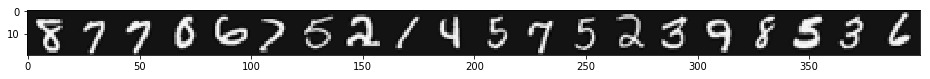

In [3]:
ran_samp = np.random.choice(X.shape[0], 20)
plt.figure(figsize = (16, 16))
plt.imshow(X[ran_samp, 1:].reshape(-1, 20).T, cmap = cm.Greys_r) 

So one row of X is the grayscale values corresponding to one of the numbers above. Meanwhile, one element of y is the text representation or the label for one of the above pictures.

Because of the nature of neural networks, we need to convert the elements of y from scalar or real numbers into vectors. This is called one-hot encoding. Basically we will create a vector with nine 0s and one 1 for each unique label we have in our data. Our data only take on the values 0-9, so that's 10 one-hot encoded vectors. In other words, one-hot encoding converts a class label n (out of k classes) into a vector of length k, where the index n is "hot" (1) while the rest are zero. We will then fill a "y matrix" with these vectors. Luckily for us, Scikit-learn, a machine learning library, is already set up to do this.

In [4]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot, y_onehot.shape

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]), (5000, 10))

We could also use pandas for this! I prefer scikit-learn, though, so this notebook will use the above variables. But, for your reference:

In [5]:
import pandas as pd
y_matrix = pd.get_dummies(y.ravel()).as_matrix() 
y_matrix, y_matrix.shape

(array([[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=uint8), (5000, 10))

Now that our data is all set up, it's time for the main event. The neural network Andrew Ng has asked us to build has an input layer corresponding to the features of our data (400 + the bias or intercept term), a hidden layer with 25 units (26 if you include the bias unit), and an output layer with 10 units for each of our class labels. If you're feeling frisky and want more info, please check out the PDF in this repo, which also contains a picture of our network architecture.

Let's first code up the sigmoid or logistic function, which converts real numbers into probabilities. This function, g(z), is defined as:

#### Sigmoid or logistic function
#### $$ g(z) = \frac{1}{1+e^{-z}}$$

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Not too bad, right? Now let's draw a plot and see if it will give us that beautiful 'S' line.

Text(0.5,1,'Sigmoid S')

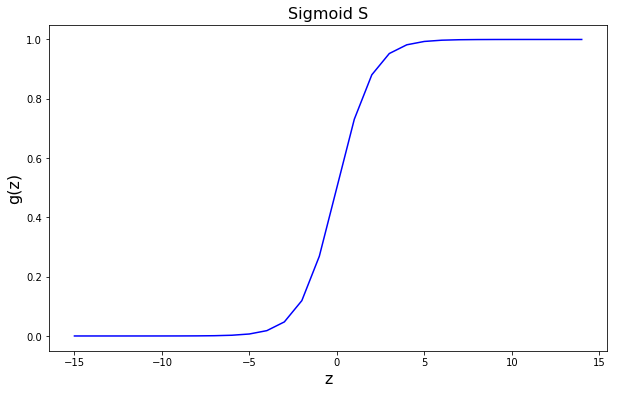

In [7]:
digits = np.arange(-15, 15, step=1)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(digits, sigmoid(digits), 'b')
plt.xlabel('z',fontsize=16)
plt.ylabel('g(z)',fontsize=16)
plt.title('Sigmoid S',fontsize=16)

Notice how the sigmoid function asymptotes at 0 and 1? That means it's smashed all our values into probabilities. This type of function is called the activation function and is repeated over and over again in neural networks. If you're familiar with logistic regression, neural networks are often called "stacked logistic regression."

Because the sigmoid function asymptotes at 0 and 1, the derivative at those values is close to 0, which slows learning down. In modern machine learning or deep learning, people typically use tanh, ReLu (rectified linear unit), or leaky ReLu as their activation function, because those don't suffer from the near-zero derivative problem. But who am I to argue with Andrew Ng? At any rate, I think you'll find ol' sigmoid does just fine for this task.

Now let's do random intialization. We need to set up a matrix to store and update our parameter values for each layer of our network, excluding the input layer. In this case, that's two layers: one hidden layer and one output layer. We will then fill the matrix with small random values. We use random-intialization to let each unit in our network learn its own unique and interesting function. If we did zero-intialization, each node would be learning the same function and be redundant.

First, we need to set up the parameters of our neural network. These are also given in the exercise PDF, but for your reference, dear reader:
#### Neural Network
Input layer size = 400 (20x20 pixels) <br>
Hidden layer size = 25 <br>
Number of labels = 10 <br>
Regularization parameter = 1

In [21]:
# initial setup
input_size = 400
hidden_size = 25
num_labels = 10
reg = 1

In order to do random initialization, we need to set up the value $\epsilon$ to multiply our theta matrices full of random values by.

$$ \epsilon = \frac{\sqrt{6}} {\sqrt{L_{in} + L_{out}}}$$
where $$ L_{in} = s_l $$  and  $$ L_{out} = s_{l+1} $$

In [52]:
init_epi1 = np.sqrt(6)/np.sqrt((input_size + 1) + (hidden_size))
init_epi2 = np.sqrt(6)/np.sqrt((hidden_size + 1) + (num_labels))

Now let's randomly generate the values of our two matrices, multiply them by our epsilons *2, subtract the resulting matrices by the inital epsilons, and unroll them into a looooooooooooooong parameter vector, theta_vec.

In [53]:
theta1 = np.random.rand((hidden_size), (input_size + 1)) * (2 * init_epi1) - init_epi1
theta2 = np.random.rand((num_labels), (hidden_size + 1)) * (2 * init_epi2) - init_epi2
theta_vec = np.concatenate((np.ravel(theta1), np.ravel(theta2)))
theta_vec = theta_vec.reshape((len(theta_vec), 1))
theta1.shape, theta2.shape, theta_vec.shape

((25, 401), (10, 26), (10285, 1))

We use theta_vec to avoid crashing the code later when using scipy's optimization functionality.

Now we need to write some code for forward propagation.

#### Forward Propagation
$$ a^{(1)} = X $$
$$ z^{(2)} = a^{(1)}\Theta^{(1)T} $$
$$ a^{(2)} = g(z^{(2)}) \quad (add \quad a_0^{(2)} = 1) $$
$$ z^{(3)} = a^{(2)} \Theta^{(2)T}$$
$$ a^{(3)} = h_\Theta(x) = g(z^{(3)}) $$

Forward propagation essentially computes our hypothesis or our network's guess based on our current parameter values. We denote our hypothesis by the letter 'h', which is dependent on computations from the previous layers. As we update our parameters (our theta matrixes) our hypthothesis will also change. We will return the values for each layer in order to do backpropagation later. Remember: for-loops should be avoided at all costs so we need to vectorize our approach.

In [54]:
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    
    
    a1 = X
    z2 = a1.dot(theta1.T) # 5000x401 * 401x25 = 5000x25
    #ones for the bias unit
    a2 = np.insert(sigmoid(z2), 0, values = np.ones(m), axis = 1)
    z3 = a2.dot(theta2.T) # 5000x26 * 26x10 = 5000x10
    h = sigmoid(z3) # = a3 = g(z3)
    
    return a1, z2, a2, z3, h

Now we need to create our cost function, which is a beast! The equations for both the cost function with and without regularization are given below. 

#### Cost Function 
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\big]$$

#### Regularized Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\bigg]$$

The cost/loss/error function basically computes how bad our network's guess is. Our goal is to minimize our cost function, which we can do by manipulating our parameter values.

If you're intimidated by the above equations, you're not alone. The first term of the regularized cost function just computes our network's error summed up over all of our data. The second term is called regularization and it tries to keep the values of both theta matrices as small as possible. Why do we want them small? Because we're trying to avoid overfitting to our data. If we can avoid overfitting, then hopefully our model will perform well on data it has never seen before.

Now we just need to code it up!

In [55]:
def cost(theta_vec, input_size, hidden_size, num_labels, X, y, reg):
    m = X.shape[0]

    # reshape the our theta vectors into theta matrices for the hidden layer and the output layer   
    theta1 = theta_vec[0:(hidden_size * (input_size + 1))].reshape(hidden_size, (input_size + 1))
    theta2 = theta_vec[(hidden_size * (input_size + 1)):].reshape(num_labels, (hidden_size + 1))
     
    #We need h
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    J = -1 * (1 / m) * np.sum((np.log(h) * (y) + np.log(1 - h) *(1 - y))) +\
    (float(reg) / (2 * m)) * (np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))
    
    return J

Notice the lack of for-loops? Vectorization is a beautiful thing.


The worst part about all this is making sure your matrix dimensions make sense. Let's take a look and convince ourselves that we're doing something sensible.

In [56]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

... Looks reasonable I guess...


Now, let's take our cost function for a spin. This function computes how different our model's guess is from the true label. In other words, what's the difference between our hypothesis (h) and our label (y)?

In [57]:
cost(theta_vec, input_size, hidden_size, num_labels, X, y_onehot, reg)

6.925705403176362

That's not good... typically you want to see a cost below 0.6.

What we need is an algorithm to reduce our cost. We're in luck because this algorithm is called backpropagation. Backpropagation computes the partial derivatives of our parameters for each layer, excluding the input layer. We can then use the derivatives as a guide to find a local (or if we're lucky a global) minimum of our cost function. If we find a minimum, we can use its values to update the values of our parameters and minimize our cost. Because we used the sigmoid activation function, the first thing we need is a function that computes the derivative (also called the gradient) of the sigmoid function.


#### Sigmoid gradient
#### $$ \frac{d} {{dz}} g(z)  = g(z)(1 - g(z))$$
where $$ g(z) = \frac{1}{1+e^{-z}}$$


In [58]:
def sigmoid_gradient(z):
    
    return(sigmoid(z) * (1 - sigmoid(z)))

Time for backpropagation, which may be the hardest thing in all of machine learning. Because backprop is dependent the values of everything we've talked about so far, we'll bring it all together below. We will use the variable $\delta$ is represent the partial derivatives of J of theta with respect to z ($\frac{\partial}{{\partial z^{(l)}}} J(\Theta)$) which is just a vector. This capital delta ($\Delta$) is a matrix of all theses partial derivatives. Then by accumlating all these derivatives and following the equations below, we can put them together into D which becomes the partial derivative of J of theta with respect to a given theta, in other words, a Jacobian of our cost function, J. ($\frac{\partial}{{\partial \Theta^{(l)}}} J(\Theta)$)  

Remember, daddio, for-loops are for squares!

#### Backpropagation
$$ \delta_{j}^{(l)}= \frac{\partial}{{\partial z_{j}^{(l)}}} J(\Theta)$$
$$ \delta^{(3)} = a^{(3)} - y = h_\Theta(x) - y $$ 
$$ \delta^{(2)} = \Theta^{(2)T}\delta^{(3)T}(\frac{\partial} {{\partial z}}g(z^{(2)}))^T $$
$$ \Delta^{(l)} := \Delta^{(l)} + \delta^{(l+1)}(a^{(l)})^T $$
$$ D^{(l)} := \frac{1} {{m}} \Delta^{(l)}+ \frac{\lambda} {{m}} \Theta^{(l)} \quad if \quad j \neq 0 $$
$$ D^{(l)} := \frac{1} {{m}} \Delta^{(l)} \quad if \quad j = 0 $$

$$ D^{(l)} = \frac{\partial}{{\partial \Theta^{(l)}}} J(\Theta) $$

In [59]:
def backprop(theta_vec, input_size, hidden_size, num_labels, X, y, reg):
    m = X.shape[0]
    # reshape the our theta vectors into theta matrices for the hidden layer and the output layer
    theta1 = theta_vec[0:(hidden_size * (input_size + 1))].reshape(hidden_size, (input_size +1))
    theta2 = theta_vec[(hidden_size * (input_size + 1)):].reshape(num_labels, (hidden_size + 1))
   
    
    # propagate the network with a guess
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost of that guess
    J = cost(theta_vec, input_size, hidden_size, num_labels, X, y, reg)
     
    
   # perform backprop so we can try to make a better guess next time
    d3 = h - y

    d2 = theta2[:,1:].T.dot(d3.T) * sigmoid_gradient(z2).T # 25x10 * 10x5000 * 25x5000 = 25x5000
     
  
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape) # (10, 26)
    
    delta1 = delta1 + d2.dot(a1) # 25x5000 * 5000x401 = 25x401
    delta2 = delta2 + d3.T.dot(a2) # 10x5000 * 5000x26 = 10x26
       
    delta1[:,0] = delta1[:,0] / m
    delta2[:,0] = delta2[:,0] / m
    
    #regularization
    delta1[:,1:] = delta1[:,1:] + ((theta1[:, 1:] * reg) / m)
    delta2[:,1:] = delta2[:,1:] + ((theta2[:, 1:] * reg) / m)
    
    
  
    #combine our two theta matrices into a row vector
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    grad = grad.reshape(len(grad), 1)
    
    
    return J, grad

The purpose of backpropagation is to calculate the gradient of our theta weight matrices. In order to do that for each theta, we need the "error" associated with each layer, which is represented by our delta variable. Through a mathematical proof you can find in this repo, you can show that the partial derivative of a given theta is the activation layer that theta maps from multiplied by the delta of the layer that theta maps to, so we need all deltas and all activations to calculate the complete gradient of our cost function. With the graident calculated, we can minimize the cost function by finding the optimal values of each theta matrix that yield the best results.

Once you understand the purpose of backprop-no small feat-, the only hard part is getting your matrix dimensions right, which is the hardest part of any machine learning task. I recommend liberal use of ".shape". 


Let's take a look and hope it outputs something meaningful and doesn't crash.

In [60]:
J, grad = backprop(theta_vec, input_size, hidden_size, num_labels, X, y_onehot, reg)
J, grad.shape

(6.925705403176362, (10285, 1))

Okay, now we can use the output of backprop to minimize our cost function. One way to do that is gradient descent, which is an iterative algorithm that just repeats backprop until convergence or our cost is small enough that we don't care to minimize it anymore. Instead, let's use scipy's more intelligent minimization functions that do that same thing as gradient descent only faster. For more info, please see https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html.

We just need to pass it backprop, our initial guess (random initializations of our parameters(theta_vec)), and the same variables we gave backprop. Then scipy will do the rest!

In [61]:
from scipy.optimize import minimize

# minimize our cost function
res = minimize(fun=backprop, x0=theta_vec, args=(input_size, hidden_size, num_labels, X, y_onehot, reg), 
                method='TNC', jac=True, options={'maxiter': 5000})
res

     fun: 0.4984933717548081
     jac: array([[ 2.11600423e-03],
       [ 2.19416014e-05],
       [ 2.18653996e-05],
       ...,
       [ 5.44586109e-01],
       [ 3.79660478e+00],
       [-4.48744461e-01]])
 message: 'Linear search failed'
    nfev: 237
     nit: 12
  status: 4
 success: False
       x: array([-0.05433001,  0.10970801,  0.109327  , ..., -0.21809121,
       -0.9881712 ,  0.33946387])

We converged~ yay~ 

As you can see, this function outputs a solution array containing the optimized values of our parameters. Our total cost is below 0.5, so at that's an encouraging sign that we've done something right. Now we can use our optimized parameter values from the solution arrary, forward propagate them through our network, and make some predictions.

In [62]:
# reshape the our theta vector into theta matrices for the hidden layer and the output layer 
# this time using the solution array
theta1 = res.x[0:(hidden_size * (input_size + 1))].reshape(hidden_size, (input_size + 1))
theta2 = res.x[(hidden_size * (input_size + 1)):].reshape(num_labels, (hidden_size + 1))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)

#because of python indexing add one to get true value predictions
predictions = np.array(np.argmax(h, axis=1) + 1)

At long last we can finally see if our neural network makes decent predictions. The way to do this is by comparing our network's output with the true label. Then, we can divide our total number of successes by the number of guesses we made, in our case, 5,000. This metric is called accuracy.

To my great shame, dear reader, there is a for-loop below. I hope you will find it in your heart to forgive me.

In [63]:
correct = [1 if a == b else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) / len(correct))
print('accuracy = {0}%'.format(accuracy * 100))

accuracy = 96.04%


Too legit! Due to random intialization, the accuracy might jump around by 2% or so, but this is a nice result, very similar to what Andrew Ng's exercise indicated we should expect.

Should we take a deeper look at the artificial brain we just cooked up? Of course we should! Remember our theta1? The parameter matrix of our network's hidden layer? Well, it turns out we can use those parameter values to visualize the picture features our network was learning at that point in training. Let's pry open this neural blackbox and take a look under the hood!

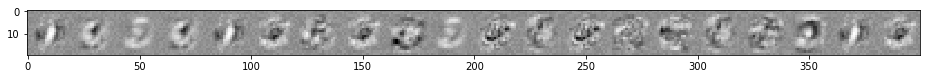

In [65]:
ran_samp = np.random.choice(theta1.shape[0], 20)
plt.figure(figsize = (16, 16))
plt.imshow(theta1[ran_samp, 1:].reshape(-1, 20).T, cmap = cm.Greys_r)

Woah! You can almost see numbers starting to form, like the network is beginning to understand what a handwritten number might look like.

We just coded up a completely vectorized, feed-forward neural network with backpropagation without using any neural network libraries like Tensorflow, Pytorch or Theano. We then used our network to classify images of handwritten digits, which is an important task in computer vision. 

Now, let's check out Keras, a neural network library in Python, and build our neural network there as well.

We've actually been cheating by training our network and testing our network on the same data set. In order to get an idea of how accurately our model will perform in a real world scenario, we need to divide our data into a training set and a test or validation set. In small data settings, like this one, this is typically done by allocating 80% of the data to the training set and 20% to the test set. However, we're now faced with a problem: our data is logically ordered! This is bad because it will limit our model's exposure certain data types. We can overcome this combining the data into a pandas dataframe and randomly shuffling it with scikit learn.

In [29]:
import pandas as pd
data2 = pd.DataFrame(data['X'])

#add y to the new dataframe
data2['y'] = data['y']

from sklearn.utils import shuffle
data2 = shuffle(data2)

In [48]:
#reconvert to appropriate dimensions
y = np.matrix(data2['y']).T
X = data2.iloc[:, 0:400]

Now we can once again use scikit learn to create our one-hot encoded vectors and additionally we can use it to split our data up into 80% for training and 20% for testing.

In [49]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 400), (1000, 400), (4000, 10), (1000, 10))

Now let's build our network! We'll use Sequential to indicate that the layers of our model are linearly ordered. We then use Dense to indicate that each unit or neuron is connected to each unit or neuron in the next layer.

We will add one hidden layer with 25 units or neurons where we will once again use the sigmoid activation function. The input shape the hidden layer matches the number of features in our model, in this case 400 (20x20 pixel images). We don't need to add the bias term, because Keras does that for us automatically. Our output layer will also use the sigmoid activation function, but with only 10 neurons corresponding to the 10 (0-9) possible values we're trying to predict.

To be consistent with Andrew Ng, I am using the sigmoid activation function, but there are other activation functions availble, even more useful than our beloved sigmoid function. Check them out and play with them: https://keras.io/activations/

Note that, in this case, the final layer should use either softmax or sigmoid activation in order to yield a probability.

In [120]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
 
model = Sequential()
model.add(Dense(25, activation='sigmoid', input_shape=(400,)))
model.add(Dense(10, activation='sigmoid'))

Now we'll configure the model. My choices for the optimizer and cost function are again to be consistent with Andrew Ng, but they are essentially arbitrary, similar to the optimization function chosen above. Feel free to play around with them and check out how the results change!
For more info see:


https://keras.io/losses/   
https://keras.io/optimizers/.

In [121]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

Batch size is the number of training samples we forward propogate into the network at a time. Epochs just mean the number of times the network sees the data (iterations).

In general, larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster. Models typically improve with more epochs of training, to a point. They'll start to plateau in accuracy as they converge.

We'll save our model as history so we can use the values later for drawing plots

In [122]:
history = model.fit(X_train, y_train, batch_size=64, epochs=1000, verbose=1, validation_data=(X_test, y_test))

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 0s 124us/step - loss: 2.3258 - acc: 0.0880 - val_loss: 2.3140 - val_acc: 0.0990
Epoch 2/1000
4000/4000 [==============================] - 0s 23us/step - loss: 2.3144 - acc: 0.0905 - val_loss: 2.3041 - val_acc: 0.1020
Epoch 3/1000
4000/4000 [==============================] - 0s 23us/step - loss: 2.3047 - acc: 0.0938 - val_loss: 2.2957 - val_acc: 0.1030
Epoch 4/1000
4000/4000 [==============================] - 0s 23us/step - loss: 2.2964 - acc: 0.0980 - val_loss: 2.2882 - val_acc: 0.1100
Epoch 5/1000
4000/4000 [==============================] - 0s 22us/step - loss: 2.2887 - acc: 0.1028 - val_loss: 2.2813 - val_acc: 0.1130
Epoch 6/1000
4000/4000 [==============================] - 0s 25us/step - loss: 2.2815 - acc: 0.1137 - val_loss: 2.2747 - val_acc: 0.1280
Epoch 7/1000
4000/4000 [==============================] - 0s 25us/step - loss: 2.2747 - acc: 0.1275 - val_loss: 2.2685 - val_acc:

4000/4000 [==============================] - 0s 23us/step - loss: 1.4911 - acc: 0.7720 - val_loss: 1.4808 - val_acc: 0.7790
Epoch 61/1000
4000/4000 [==============================] - 0s 24us/step - loss: 1.4705 - acc: 0.7747 - val_loss: 1.4603 - val_acc: 0.7790
Epoch 62/1000
4000/4000 [==============================] - 0s 25us/step - loss: 1.4504 - acc: 0.7752 - val_loss: 1.4402 - val_acc: 0.7790
Epoch 63/1000
4000/4000 [==============================] - 0s 23us/step - loss: 1.4305 - acc: 0.7755 - val_loss: 1.4208 - val_acc: 0.7790
Epoch 64/1000
4000/4000 [==============================] - 0s 23us/step - loss: 1.4110 - acc: 0.7785 - val_loss: 1.4013 - val_acc: 0.7800
Epoch 65/1000
4000/4000 [==============================] - 0s 27us/step - loss: 1.3917 - acc: 0.7785 - val_loss: 1.3822 - val_acc: 0.7800
Epoch 66/1000
4000/4000 [==============================] - 0s 27us/step - loss: 1.3727 - acc: 0.7785 - val_loss: 1.3634 - val_acc: 0.7810
Epoch 67/1000
4000/4000 [=======================

4000/4000 [==============================] - 0s 22us/step - loss: 0.5456 - acc: 0.8815 - val_loss: 0.5447 - val_acc: 0.8800
Epoch 179/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.5431 - acc: 0.8812 - val_loss: 0.5423 - val_acc: 0.8800
Epoch 180/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.5406 - acc: 0.8822 - val_loss: 0.5400 - val_acc: 0.8800
Epoch 181/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.5382 - acc: 0.8817 - val_loss: 0.5377 - val_acc: 0.8800
Epoch 182/1000
4000/4000 [==============================] - 0s 22us/step - loss: 0.5357 - acc: 0.8838 - val_loss: 0.5355 - val_acc: 0.8820
Epoch 183/1000
4000/4000 [==============================] - 0s 22us/step - loss: 0.5334 - acc: 0.8822 - val_loss: 0.5333 - val_acc: 0.8820
Epoch 184/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.5311 - acc: 0.8832 - val_loss: 0.5311 - val_acc: 0.8820
Epoch 185/1000
4000/4000 [================

4000/4000 [==============================] - 0s 24us/step - loss: 0.4381 - acc: 0.9015 - val_loss: 0.4465 - val_acc: 0.8950
Epoch 238/1000
4000/4000 [==============================] - 0s 22us/step - loss: 0.4367 - acc: 0.9015 - val_loss: 0.4453 - val_acc: 0.8970
Epoch 239/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.4355 - acc: 0.9022 - val_loss: 0.4442 - val_acc: 0.8950
Epoch 240/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.4342 - acc: 0.9027 - val_loss: 0.4431 - val_acc: 0.8960
Epoch 241/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.4329 - acc: 0.9030 - val_loss: 0.4421 - val_acc: 0.8960
Epoch 242/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.4317 - acc: 0.9035 - val_loss: 0.4409 - val_acc: 0.8970
Epoch 243/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.4304 - acc: 0.9030 - val_loss: 0.4398 - val_acc: 0.8980
Epoch 244/1000
4000/4000 [================

4000/4000 [==============================] - 0s 27us/step - loss: 0.3768 - acc: 0.9130 - val_loss: 0.3943 - val_acc: 0.9020
Epoch 297/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.3759 - acc: 0.9130 - val_loss: 0.3936 - val_acc: 0.9020
Epoch 298/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.3751 - acc: 0.9130 - val_loss: 0.3929 - val_acc: 0.9030
Epoch 299/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.3743 - acc: 0.9137 - val_loss: 0.3922 - val_acc: 0.9030
Epoch 300/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.3735 - acc: 0.9133 - val_loss: 0.3915 - val_acc: 0.9030
Epoch 301/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.3728 - acc: 0.9143 - val_loss: 0.3909 - val_acc: 0.9030
Epoch 302/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.3719 - acc: 0.9145 - val_loss: 0.3903 - val_acc: 0.9030
Epoch 303/1000
4000/4000 [================

4000/4000 [==============================] - 0s 22us/step - loss: 0.3364 - acc: 0.9188 - val_loss: 0.3624 - val_acc: 0.9120
Epoch 356/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.3359 - acc: 0.9195 - val_loss: 0.3619 - val_acc: 0.9120
Epoch 357/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3352 - acc: 0.9197 - val_loss: 0.3615 - val_acc: 0.9130
Epoch 358/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.3347 - acc: 0.9197 - val_loss: 0.3611 - val_acc: 0.9130
Epoch 359/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.3341 - acc: 0.9193 - val_loss: 0.3607 - val_acc: 0.9130
Epoch 360/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.3336 - acc: 0.9197 - val_loss: 0.3602 - val_acc: 0.9130
Epoch 361/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3330 - acc: 0.9200 - val_loss: 0.3598 - val_acc: 0.9130
Epoch 362/1000
4000/4000 [================

4000/4000 [==============================] - 0s 23us/step - loss: 0.3072 - acc: 0.9237 - val_loss: 0.3412 - val_acc: 0.9180
Epoch 415/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.3067 - acc: 0.9240 - val_loss: 0.3409 - val_acc: 0.9180
Epoch 416/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3063 - acc: 0.9248 - val_loss: 0.3406 - val_acc: 0.9180
Epoch 417/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.3059 - acc: 0.9245 - val_loss: 0.3404 - val_acc: 0.9180
Epoch 418/1000
4000/4000 [==============================] - 0s 22us/step - loss: 0.3055 - acc: 0.9243 - val_loss: 0.3400 - val_acc: 0.9180
Epoch 419/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3050 - acc: 0.9237 - val_loss: 0.3398 - val_acc: 0.9180
Epoch 420/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.3046 - acc: 0.9243 - val_loss: 0.3395 - val_acc: 0.9180
Epoch 421/1000
4000/4000 [================

4000/4000 [==============================] - 0s 24us/step - loss: 0.2845 - acc: 0.9303 - val_loss: 0.3261 - val_acc: 0.9190
Epoch 474/1000
4000/4000 [==============================] - ETA: 0s - loss: 0.2945 - acc: 0.925 - 0s 22us/step - loss: 0.2841 - acc: 0.9295 - val_loss: 0.3260 - val_acc: 0.9180
Epoch 475/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.2838 - acc: 0.9297 - val_loss: 0.3257 - val_acc: 0.9180
Epoch 476/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.2835 - acc: 0.9303 - val_loss: 0.3254 - val_acc: 0.9190
Epoch 477/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.2831 - acc: 0.9293 - val_loss: 0.3253 - val_acc: 0.9190
Epoch 478/1000
4000/4000 [==============================] - 0s 22us/step - loss: 0.2828 - acc: 0.9295 - val_loss: 0.3250 - val_acc: 0.9190
Epoch 479/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.2825 - acc: 0.9295 - val_loss: 0.3248 - val_acc: 0.9190
Epoc

Epoch 532/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.2661 - acc: 0.9360 - val_loss: 0.3148 - val_acc: 0.9190
Epoch 533/1000
4000/4000 [==============================] - 0s 22us/step - loss: 0.2658 - acc: 0.9355 - val_loss: 0.3147 - val_acc: 0.9180
Epoch 534/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.2655 - acc: 0.9357 - val_loss: 0.3144 - val_acc: 0.9190
Epoch 535/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.2652 - acc: 0.9360 - val_loss: 0.3143 - val_acc: 0.9190
Epoch 536/1000
4000/4000 [==============================] - 0s 22us/step - loss: 0.2650 - acc: 0.9355 - val_loss: 0.3141 - val_acc: 0.9190
Epoch 537/1000
4000/4000 [==============================] - 0s 22us/step - loss: 0.2647 - acc: 0.9360 - val_loss: 0.3140 - val_acc: 0.9190
Epoch 538/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.2644 - acc: 0.9365 - val_loss: 0.3138 - val_acc: 0.9190
Epoch 539/1000
4000/4000 [=

Epoch 591/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.2506 - acc: 0.9393 - val_loss: 0.3062 - val_acc: 0.9190
Epoch 592/1000
4000/4000 [==============================] - 0s 22us/step - loss: 0.2504 - acc: 0.9390 - val_loss: 0.3060 - val_acc: 0.9190
Epoch 593/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.2501 - acc: 0.9387 - val_loss: 0.3058 - val_acc: 0.9200
Epoch 594/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.2499 - acc: 0.9395 - val_loss: 0.3058 - val_acc: 0.9190
Epoch 595/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.2496 - acc: 0.9390 - val_loss: 0.3056 - val_acc: 0.9190
Epoch 596/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.2494 - acc: 0.9397 - val_loss: 0.3055 - val_acc: 0.9200
Epoch 597/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.2492 - acc: 0.9390 - val_loss: 0.3053 - val_acc: 0.9200
Epoch 598/1000
4000/4000 [=

Epoch 650/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.2373 - acc: 0.9415 - val_loss: 0.2992 - val_acc: 0.9180
Epoch 651/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.2371 - acc: 0.9415 - val_loss: 0.2992 - val_acc: 0.9180
Epoch 652/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.2369 - acc: 0.9423 - val_loss: 0.2990 - val_acc: 0.9180
Epoch 653/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.2366 - acc: 0.9420 - val_loss: 0.2989 - val_acc: 0.9180
Epoch 654/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.2364 - acc: 0.9415 - val_loss: 0.2988 - val_acc: 0.9180
Epoch 655/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.2362 - acc: 0.9417 - val_loss: 0.2987 - val_acc: 0.9180
Epoch 656/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.2360 - acc: 0.9417 - val_loss: 0.2985 - val_acc: 0.9180
Epoch 657/1000
4000/4000 [=

Epoch 709/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.2256 - acc: 0.9445 - val_loss: 0.2935 - val_acc: 0.9180
Epoch 710/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.2254 - acc: 0.9442 - val_loss: 0.2934 - val_acc: 0.9180
Epoch 711/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.2252 - acc: 0.9447 - val_loss: 0.2933 - val_acc: 0.9180
Epoch 712/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.2250 - acc: 0.9447 - val_loss: 0.2933 - val_acc: 0.9180
Epoch 713/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.2248 - acc: 0.9442 - val_loss: 0.2932 - val_acc: 0.9180
Epoch 714/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.2246 - acc: 0.9447 - val_loss: 0.2932 - val_acc: 0.9180
Epoch 715/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.2245 - acc: 0.9442 - val_loss: 0.2930 - val_acc: 0.9180
Epoch 716/1000
4000/4000 [=

Epoch 768/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.2151 - acc: 0.9467 - val_loss: 0.2888 - val_acc: 0.9160
Epoch 769/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.2150 - acc: 0.9470 - val_loss: 0.2887 - val_acc: 0.9160
Epoch 770/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.2148 - acc: 0.9470 - val_loss: 0.2887 - val_acc: 0.9160
Epoch 771/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.2147 - acc: 0.9463 - val_loss: 0.2885 - val_acc: 0.9160
Epoch 772/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.2145 - acc: 0.9472 - val_loss: 0.2886 - val_acc: 0.9160
Epoch 773/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.2143 - acc: 0.9472 - val_loss: 0.2885 - val_acc: 0.9160
Epoch 774/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.2142 - acc: 0.9472 - val_loss: 0.2883 - val_acc: 0.9160
Epoch 775/1000
4000/4000 [=

Epoch 827/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.2057 - acc: 0.9485 - val_loss: 0.2847 - val_acc: 0.9180
Epoch 828/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.2056 - acc: 0.9490 - val_loss: 0.2847 - val_acc: 0.9180
Epoch 829/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.2054 - acc: 0.9483 - val_loss: 0.2846 - val_acc: 0.9180
Epoch 830/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.2053 - acc: 0.9485 - val_loss: 0.2844 - val_acc: 0.9190
Epoch 831/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.2051 - acc: 0.9490 - val_loss: 0.2844 - val_acc: 0.9180
Epoch 832/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.2050 - acc: 0.9487 - val_loss: 0.2845 - val_acc: 0.9180
Epoch 833/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.2048 - acc: 0.9493 - val_loss: 0.2844 - val_acc: 0.9180
Epoch 834/1000
4000/4000 [=

Epoch 886/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.1972 - acc: 0.9507 - val_loss: 0.2812 - val_acc: 0.9190
Epoch 887/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.1970 - acc: 0.9510 - val_loss: 0.2812 - val_acc: 0.9190
Epoch 888/1000
4000/4000 [==============================] - 0s 37us/step - loss: 0.1969 - acc: 0.9505 - val_loss: 0.2811 - val_acc: 0.9190
Epoch 889/1000
4000/4000 [==============================] - 0s 33us/step - loss: 0.1967 - acc: 0.9510 - val_loss: 0.2810 - val_acc: 0.9190
Epoch 890/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.1966 - acc: 0.9510 - val_loss: 0.2810 - val_acc: 0.9190
Epoch 891/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.1964 - acc: 0.9510 - val_loss: 0.2809 - val_acc: 0.9190
Epoch 892/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.1963 - acc: 0.9507 - val_loss: 0.2809 - val_acc: 0.9190
Epoch 893/1000
4000/4000 [=

Epoch 945/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.1893 - acc: 0.9525 - val_loss: 0.2782 - val_acc: 0.9200
Epoch 946/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.1891 - acc: 0.9530 - val_loss: 0.2782 - val_acc: 0.9200
Epoch 947/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.1890 - acc: 0.9520 - val_loss: 0.2782 - val_acc: 0.9200
Epoch 948/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.1889 - acc: 0.9527 - val_loss: 0.2781 - val_acc: 0.9200
Epoch 949/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.1888 - acc: 0.9525 - val_loss: 0.2780 - val_acc: 0.9190
Epoch 950/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.1886 - acc: 0.9530 - val_loss: 0.2780 - val_acc: 0.9190
Epoch 951/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.1885 - acc: 0.9530 - val_loss: 0.2779 - val_acc: 0.9200
Epoch 952/1000
4000/4000 [=

Now let's see how we did!

In [123]:
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

1000/1000 [==============================] - 0s 19us/step
Evaluation result on Test Data : Cost = 0.2756446511745453, accuracy = 92.30000000000001


Not too shabby! Not as good as our hand-crafted model, but remember, we cheated then! Let's draw some plots to visualize our cost and accuracy as the model became more familiar with the data. 

Text(0.5,1,'Accuracy Curves')

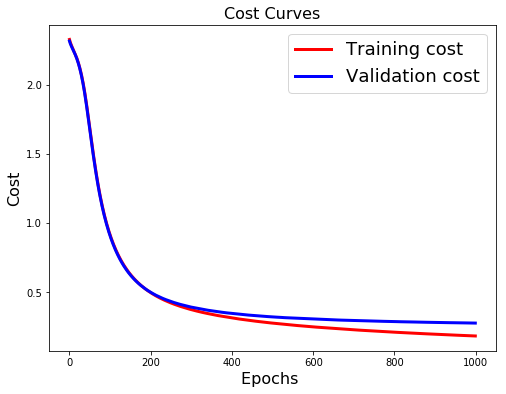

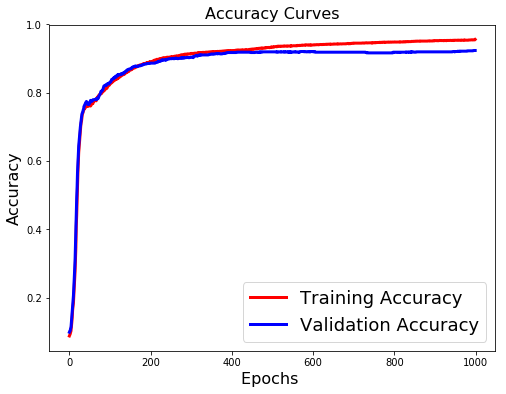

In [124]:
#Plot cost
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training cost', 'Validation cost'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Cost',fontsize=16)
plt.title('Cost Curves',fontsize=16)
 
#Plot accuracy
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

As you can see, our training cost and accuracy only get better the more the model sees the data, while for the validation set, we've plateaued! This is a clear indicator that our model is overfit. In fact if you crank up the Epochs to 1000 or 10000, you'd see the test cost and accuracy get worse and worse while the training cost and accuracy get better and better. So, more Epochs in not necessarily a good thing! One fix for this overfitting problem is called dropout. You can think of dropout as additional neural network regularization, on top of the regularization we already implemented.

In a nut shell, dropout randomly turns off a percentage of the units or neurons in a given layer which discourages overfitting. Since the hidden size of the neural network in this assignment is very small, we'll only shut off 15% of the neurons. In neural networks with larger hidden sizes, the dropout number is usually much higher, like 50%.

In [111]:
from keras.layers import Dropout
 
model_dropout = Sequential()
model_dropout.add(Dense(25, activation='sigmoid', input_shape=(400,)))
model_dropout.add(Dropout(0.15))
model_dropout.add(Dense(10, activation='sigmoid'))

Now we can just configure a new model in the same way as before!

In [112]:
model_dropout.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history_dropout = model_dropout.fit(X_train, y_train, batch_size=64, epochs=1000, verbose=1, validation_data=(X_test, y_test))

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 0s 113us/step - loss: 2.3313 - acc: 0.0877 - val_loss: 2.3314 - val_acc: 0.0500
Epoch 2/1000
4000/4000 [==============================] - 0s 24us/step - loss: 2.3227 - acc: 0.0865 - val_loss: 2.3182 - val_acc: 0.0570
Epoch 3/1000
4000/4000 [==============================] - 0s 25us/step - loss: 2.3109 - acc: 0.0940 - val_loss: 2.3079 - val_acc: 0.0640
Epoch 4/1000
4000/4000 [==============================] - 0s 24us/step - loss: 2.2993 - acc: 0.0985 - val_loss: 2.2992 - val_acc: 0.0750
Epoch 5/1000
4000/4000 [==============================] - 0s 29us/step - loss: 2.2926 - acc: 0.1028 - val_loss: 2.2916 - val_acc: 0.0900
Epoch 6/1000
4000/4000 [==============================] - 0s 27us/step - loss: 2.2872 - acc: 0.1090 - val_loss: 2.2847 - val_acc: 0.0980
Epoch 7/1000
4000/4000 [==============================] - 0s 27us/step - loss: 2.2840 - acc: 0.1170 - val_loss: 2.2783 - val_acc:

4000/4000 [==============================] - 0s 26us/step - loss: 1.7263 - acc: 0.5687 - val_loss: 1.6805 - val_acc: 0.7350
Epoch 61/1000
4000/4000 [==============================] - 0s 25us/step - loss: 1.7084 - acc: 0.5605 - val_loss: 1.6627 - val_acc: 0.7370
Epoch 62/1000
4000/4000 [==============================] - 0s 25us/step - loss: 1.6974 - acc: 0.5700 - val_loss: 1.6454 - val_acc: 0.7390
Epoch 63/1000
4000/4000 [==============================] - 0s 26us/step - loss: 1.6822 - acc: 0.5700 - val_loss: 1.6280 - val_acc: 0.7400
Epoch 64/1000
4000/4000 [==============================] - 0s 24us/step - loss: 1.6679 - acc: 0.5735 - val_loss: 1.6108 - val_acc: 0.7430
Epoch 65/1000
4000/4000 [==============================] - 0s 24us/step - loss: 1.6480 - acc: 0.5820 - val_loss: 1.5933 - val_acc: 0.7440
Epoch 66/1000
4000/4000 [==============================] - 0s 28us/step - loss: 1.6316 - acc: 0.5872 - val_loss: 1.5762 - val_acc: 0.7490
Epoch 67/1000
4000/4000 [=======================

4000/4000 [==============================] - 0s 28us/step - loss: 0.7491 - acc: 0.8000 - val_loss: 0.6267 - val_acc: 0.8720
Epoch 179/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.7411 - acc: 0.7987 - val_loss: 0.6237 - val_acc: 0.8720
Epoch 180/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.7415 - acc: 0.8025 - val_loss: 0.6208 - val_acc: 0.8710
Epoch 181/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.7424 - acc: 0.7980 - val_loss: 0.6179 - val_acc: 0.8710
Epoch 182/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.7432 - acc: 0.8073 - val_loss: 0.6150 - val_acc: 0.8700
Epoch 183/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.7371 - acc: 0.8110 - val_loss: 0.6123 - val_acc: 0.8710
Epoch 184/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.7328 - acc: 0.8123 - val_loss: 0.6094 - val_acc: 0.8720
Epoch 185/1000
4000/4000 [================

4000/4000 [==============================] - 0s 28us/step - loss: 0.6165 - acc: 0.8385 - val_loss: 0.5011 - val_acc: 0.8870
Epoch 238/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.6243 - acc: 0.8325 - val_loss: 0.4994 - val_acc: 0.8870
Epoch 239/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.6150 - acc: 0.8267 - val_loss: 0.4978 - val_acc: 0.8880
Epoch 240/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.6106 - acc: 0.8390 - val_loss: 0.4963 - val_acc: 0.8880
Epoch 241/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.6119 - acc: 0.8390 - val_loss: 0.4950 - val_acc: 0.8880
Epoch 242/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.6119 - acc: 0.8387 - val_loss: 0.4937 - val_acc: 0.8880
Epoch 243/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.6089 - acc: 0.8307 - val_loss: 0.4921 - val_acc: 0.8890
Epoch 244/1000
4000/4000 [================

4000/4000 [==============================] - 0s 25us/step - loss: 0.5534 - acc: 0.8482 - val_loss: 0.4323 - val_acc: 0.9020
Epoch 297/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.5420 - acc: 0.8478 - val_loss: 0.4314 - val_acc: 0.9020
Epoch 298/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.5461 - acc: 0.8500 - val_loss: 0.4307 - val_acc: 0.9000
Epoch 299/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.5407 - acc: 0.8555 - val_loss: 0.4299 - val_acc: 0.9000
Epoch 300/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.5324 - acc: 0.8500 - val_loss: 0.4291 - val_acc: 0.9020
Epoch 301/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.5269 - acc: 0.8565 - val_loss: 0.4282 - val_acc: 0.9020
Epoch 302/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.5342 - acc: 0.8588 - val_loss: 0.4273 - val_acc: 0.9030
Epoch 303/1000
4000/4000 [================

4000/4000 [==============================] - 0s 27us/step - loss: 0.4934 - acc: 0.8625 - val_loss: 0.3908 - val_acc: 0.9070
Epoch 356/1000
4000/4000 [==============================] - 0s 33us/step - loss: 0.4884 - acc: 0.8638 - val_loss: 0.3902 - val_acc: 0.9070
Epoch 357/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.4920 - acc: 0.8600 - val_loss: 0.3896 - val_acc: 0.9070
Epoch 358/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.4864 - acc: 0.8638 - val_loss: 0.3890 - val_acc: 0.9070
Epoch 359/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.4903 - acc: 0.8698 - val_loss: 0.3885 - val_acc: 0.9070
Epoch 360/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.4774 - acc: 0.8722 - val_loss: 0.3880 - val_acc: 0.9070
Epoch 361/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.4876 - acc: 0.8685 - val_loss: 0.3875 - val_acc: 0.9070
Epoch 362/1000
4000/4000 [================

4000/4000 [==============================] - 0s 24us/step - loss: 0.4577 - acc: 0.8780 - val_loss: 0.3631 - val_acc: 0.9120
Epoch 415/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.4592 - acc: 0.8710 - val_loss: 0.3629 - val_acc: 0.9130
Epoch 416/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.4520 - acc: 0.8720 - val_loss: 0.3624 - val_acc: 0.9120
Epoch 417/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.4537 - acc: 0.8718 - val_loss: 0.3619 - val_acc: 0.9120
Epoch 418/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.4576 - acc: 0.8713 - val_loss: 0.3615 - val_acc: 0.9120
Epoch 419/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.4475 - acc: 0.8748 - val_loss: 0.3611 - val_acc: 0.9120
Epoch 420/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.4569 - acc: 0.8740 - val_loss: 0.3609 - val_acc: 0.9120
Epoch 421/1000
4000/4000 [================

4000/4000 [==============================] - 0s 28us/step - loss: 0.4239 - acc: 0.8798 - val_loss: 0.3436 - val_acc: 0.9160
Epoch 474/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.4295 - acc: 0.8770 - val_loss: 0.3434 - val_acc: 0.9160
Epoch 475/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.4292 - acc: 0.8798 - val_loss: 0.3431 - val_acc: 0.9160
Epoch 476/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.4248 - acc: 0.8835 - val_loss: 0.3428 - val_acc: 0.9160
Epoch 477/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.4249 - acc: 0.8785 - val_loss: 0.3424 - val_acc: 0.9160
Epoch 478/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.4228 - acc: 0.8787 - val_loss: 0.3423 - val_acc: 0.9160
Epoch 479/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.4311 - acc: 0.8760 - val_loss: 0.3421 - val_acc: 0.9160
Epoch 480/1000
4000/4000 [================

4000/4000 [==============================] - 0s 35us/step - loss: 0.4048 - acc: 0.8882 - val_loss: 0.3303 - val_acc: 0.9190
Epoch 533/1000
4000/4000 [==============================] - 0s 36us/step - loss: 0.4037 - acc: 0.8817 - val_loss: 0.3300 - val_acc: 0.9190
Epoch 534/1000
4000/4000 [==============================] - 0s 36us/step - loss: 0.4042 - acc: 0.8858 - val_loss: 0.3295 - val_acc: 0.9190
Epoch 535/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.4048 - acc: 0.8862 - val_loss: 0.3295 - val_acc: 0.9190
Epoch 536/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.4015 - acc: 0.8840 - val_loss: 0.3292 - val_acc: 0.9190
Epoch 537/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.4049 - acc: 0.8850 - val_loss: 0.3289 - val_acc: 0.9190
Epoch 538/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3998 - acc: 0.8860 - val_loss: 0.3288 - val_acc: 0.9190
Epoch 539/1000
4000/4000 [================

4000/4000 [==============================] - 0s 35us/step - loss: 0.3892 - acc: 0.8895 - val_loss: 0.3190 - val_acc: 0.9190
Epoch 592/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.3851 - acc: 0.8898 - val_loss: 0.3190 - val_acc: 0.9190
Epoch 593/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.3886 - acc: 0.8882 - val_loss: 0.3187 - val_acc: 0.9200
Epoch 594/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.3941 - acc: 0.8838 - val_loss: 0.3185 - val_acc: 0.9200
Epoch 595/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.3805 - acc: 0.8852 - val_loss: 0.3183 - val_acc: 0.9200
Epoch 596/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.3802 - acc: 0.8922 - val_loss: 0.3182 - val_acc: 0.9200
Epoch 597/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.3948 - acc: 0.8895 - val_loss: 0.3183 - val_acc: 0.9190
Epoch 598/1000
4000/4000 [================

4000/4000 [==============================] - 0s 24us/step - loss: 0.3813 - acc: 0.8902 - val_loss: 0.3101 - val_acc: 0.9190
Epoch 651/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.3681 - acc: 0.8935 - val_loss: 0.3098 - val_acc: 0.9190
Epoch 652/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3695 - acc: 0.8937 - val_loss: 0.3098 - val_acc: 0.9200
Epoch 653/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.3732 - acc: 0.8937 - val_loss: 0.3097 - val_acc: 0.9190
Epoch 654/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3750 - acc: 0.8858 - val_loss: 0.3097 - val_acc: 0.9180
Epoch 655/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3701 - acc: 0.8980 - val_loss: 0.3096 - val_acc: 0.9180
Epoch 656/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3786 - acc: 0.8948 - val_loss: 0.3094 - val_acc: 0.9200
Epoch 657/1000
4000/4000 [================

4000/4000 [==============================] - 0s 24us/step - loss: 0.3556 - acc: 0.8975 - val_loss: 0.3033 - val_acc: 0.9210
Epoch 710/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.3629 - acc: 0.8930 - val_loss: 0.3034 - val_acc: 0.9210
Epoch 711/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.3625 - acc: 0.8937 - val_loss: 0.3032 - val_acc: 0.9220
Epoch 712/1000
4000/4000 [==============================] - 0s 32us/step - loss: 0.3675 - acc: 0.8922 - val_loss: 0.3031 - val_acc: 0.9210
Epoch 713/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.3585 - acc: 0.9018 - val_loss: 0.3028 - val_acc: 0.9210
Epoch 714/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.3552 - acc: 0.8972 - val_loss: 0.3027 - val_acc: 0.9210
Epoch 715/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.3576 - acc: 0.8937 - val_loss: 0.3025 - val_acc: 0.9220
Epoch 716/1000
4000/4000 [================

4000/4000 [==============================] - 0s 26us/step - loss: 0.3533 - acc: 0.8962 - val_loss: 0.2977 - val_acc: 0.9220
Epoch 769/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3546 - acc: 0.8995 - val_loss: 0.2975 - val_acc: 0.9220
Epoch 770/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.3496 - acc: 0.8992 - val_loss: 0.2973 - val_acc: 0.9220
Epoch 771/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.3501 - acc: 0.8940 - val_loss: 0.2973 - val_acc: 0.9220
Epoch 772/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.3418 - acc: 0.9018 - val_loss: 0.2972 - val_acc: 0.9230
Epoch 773/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3459 - acc: 0.9018 - val_loss: 0.2971 - val_acc: 0.9230
Epoch 774/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3493 - acc: 0.8985 - val_loss: 0.2970 - val_acc: 0.9210
Epoch 775/1000
4000/4000 [================

4000/4000 [==============================] - 0s 25us/step - loss: 0.3297 - acc: 0.9030 - val_loss: 0.2928 - val_acc: 0.9240
Epoch 828/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.3295 - acc: 0.9002 - val_loss: 0.2926 - val_acc: 0.9230
Epoch 829/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.3369 - acc: 0.8978 - val_loss: 0.2925 - val_acc: 0.9220
Epoch 830/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.3358 - acc: 0.9022 - val_loss: 0.2926 - val_acc: 0.9240
Epoch 831/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3323 - acc: 0.9050 - val_loss: 0.2923 - val_acc: 0.9230
Epoch 832/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3371 - acc: 0.9000 - val_loss: 0.2923 - val_acc: 0.9240
Epoch 833/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.3428 - acc: 0.9027 - val_loss: 0.2922 - val_acc: 0.9240
Epoch 834/1000
4000/4000 [================

4000/4000 [==============================] - 0s 25us/step - loss: 0.3265 - acc: 0.9083 - val_loss: 0.2885 - val_acc: 0.9250
Epoch 887/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3342 - acc: 0.9020 - val_loss: 0.2885 - val_acc: 0.9250
Epoch 888/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.3345 - acc: 0.9010 - val_loss: 0.2886 - val_acc: 0.9250
Epoch 889/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.3219 - acc: 0.9025 - val_loss: 0.2884 - val_acc: 0.9250
Epoch 890/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3298 - acc: 0.9000 - val_loss: 0.2884 - val_acc: 0.9260
Epoch 891/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3309 - acc: 0.9035 - val_loss: 0.2882 - val_acc: 0.9250
Epoch 892/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.3311 - acc: 0.9030 - val_loss: 0.2882 - val_acc: 0.9250
Epoch 893/1000
4000/4000 [================

4000/4000 [==============================] - 0s 25us/step - loss: 0.3205 - acc: 0.9073 - val_loss: 0.2854 - val_acc: 0.9260
Epoch 946/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.3115 - acc: 0.9075 - val_loss: 0.2853 - val_acc: 0.9260
Epoch 947/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.3247 - acc: 0.9035 - val_loss: 0.2852 - val_acc: 0.9260
Epoch 948/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3176 - acc: 0.9085 - val_loss: 0.2852 - val_acc: 0.9260
Epoch 949/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3254 - acc: 0.9060 - val_loss: 0.2852 - val_acc: 0.9260
Epoch 950/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3115 - acc: 0.9083 - val_loss: 0.2854 - val_acc: 0.9260
Epoch 951/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.3189 - acc: 0.9080 - val_loss: 0.2852 - val_acc: 0.9260
Epoch 952/1000
4000/4000 [================

In [113]:
#Model with dropout evaluation
[test_cost, test_acc] = model_dropout.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

1000/1000 [==============================] - 0s 16us/step
Evaluation result on Test Data : Cost = 0.2821768097877502, accuracy = 92.60000000000001


Not bad! Behold the power of dropout!


Let's take a look at the dropout model's cost and accuracy.

Text(0.5,1,'Model with Dropout Accuracy Curves')

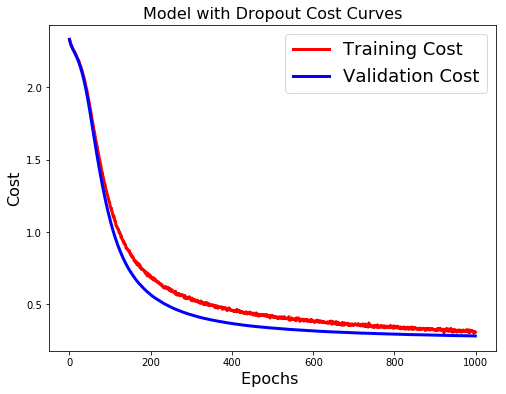

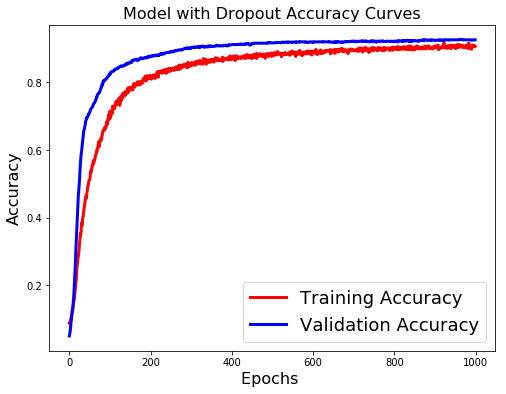

In [118]:
#Plot cost of model with dropout
plt.figure(figsize=[8,6])
plt.plot(history_dropout.history['loss'],'r',linewidth=3.0)
plt.plot(history_dropout.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Cost', 'Validation Cost'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Cost',fontsize=16)
plt.title('Model with Dropout Cost Curves',fontsize=16)
 
#Plot accuracy of model with dropout
plt.figure(figsize=[8,6])
plt.plot(history_dropout.history['acc'],'r',linewidth=3.0)
plt.plot(history_dropout.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Model with Dropout Accuracy Curves',fontsize=16)

That looks much better! We're actually more accurate on the test set than we are on the training set, but I'm sure that wouldn't be the case for long if we increased the number of Epochs. At any rate, our model is more general now.

Thanks for reading, dear reader!